# 0001 Sample Model

In [1]:
from common import setup_imports
from constants import *
import matplotlib.pyplot as plt
import seaborn as sns

import torch

setup_imports()
torch.cuda.empty_cache()

plt.style.use('ggplot')
sns.set_palette('Set2')

%load_ext autoreload
%autoreload 2


## 1. Simple Model

### Data loading from GCS / Config yamml

In [4]:
from data import create_dataloader
from utils import load_config, validate_config
from utils.data_stream import DataStream

In [6]:
config = load_config(os.path.join(CONFIG_PATH, '001_sample_config.yaml'))
config = validate_config(config)

### Diversify Images

In [7]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((config['model']['input_size'], config['model']['input_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.5), # diversify perspective
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), # diversify lighting condition
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)), # simulate noise
    transforms.RandomResizedCrop(size=416, scale=(0.8, 1.0)), # simulate altitude change
    transforms.RandomRotation(degrees=3) # diversify orientation
    
])

In [8]:
data_stream = DataStream(bucket_name=BUCKET_NAME)
train_loader, val_loader, test_loader = create_dataloader(
    config=config,
    data_stream=data_stream,
    transform=transform
)

/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Train Samples: 6129, Val Samples: 2043, Test Samples: 2043


In [10]:
from models.yolov3 import YOLOv3

model_001 = YOLOv3(n_classes=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_001 = model_001.to(device)

cuda


In [ ]:
from models.train_val.train import train_model

model_001, train_history, val_history = train_model(
    model=model_001,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device
)

Training model...
  Number of epochs: 30
  Device: cuda
  Patience: 5
  Save path: 002_sample_best_model.pt



  Epoch: 1/30 - Batch: 0/767 - Loss: 4568.7964
      (Coord: 108.5681, Obj: 2553.6973, NoObj: 1895.3165, Class: 11.2144)
  Epoch: 1/30 - Batch: 20/767 - Loss: 4099.9902
      (Coord: 159.1492, Obj: 3101.8879, NoObj: 837.2234, Class: 1.7297)
  Epoch: 1/30 - Batch: 40/767 - Loss: 3573.1792
      (Coord: 106.5212, Obj: 2702.9028, NoObj: 763.1082, Class: 0.6470)
  Epoch: 1/30 - Batch: 60/767 - Loss: 3932.3447
      (Coord: 97.3821, Obj: 3058.4685, NoObj: 776.0846, Class: 0.4097)
  Epoch: 1/30 - Batch: 80/767 - Loss: 4107.0791
      (Coord: 155.3515, Obj: 3205.3889, NoObj: 745.9846, Class: 0.3541)
  Epoch: 1/30 - Batch: 100/767 - Loss: 4178.1465
      (Coord: 185.9699, Obj: 3273.8984, NoObj: 718.0570, Class: 0.2211)
  Epoch: 1/30 - Batch: 120/767 - Loss: 3949.0859
      (Coord: 77.3664, Obj: 2976.3438, NoObj: 895.0410, Class: 0.3346)
  Epoch: 1/30 - Batch: 140/767 - Loss: 4907.1689
      (Coord: 581.3108, Obj: 3466.1357, NoObj: 859.4086, Class: 0.3140)
  Epoch: 1/30 - Batch: 160/767 - Loss:

In [ ]:
import pandas as pd
metrics = {
    'model': [],
    'epochs': [],
    'lr' : [],
    'weight_decay': [],
    'batch_size': [],
    'train_loss': [],
    'val_loss': [],
    'mAP': [],
    
}

In [3]:
from models.train_val import learning_curve

learning_curve(train_history, val_history, save_path='figures/001_learning_curve.png')

ImportError: cannot import name 'learning_curve' from 'models.train_val' (/home/automatedtomato/github.com/automatedtomato/sar-yolo/models/train_val/__init__.py)

## 2. Customize Learning Rate

In [ ]:
from data import create_dataloader
from utils import load_config, validate_config
import torch
from utils.data_stream import DataStream
import torchvision.transforms as transforms
from models.yolov3 import YOLOv3
from models.train_val.train import train_model

# PIPELINE

torch.cuda.empty_cache()

data_stream = DataStream(bucket_name=BUCKET_NAME)

config = load_config(os.path.join(CONFIG_PATH, '002_low_lr.yaml'))
config = validate_config(config)

transform = transforms.Compose([
    transforms.Resize((config['model']['input_size'], config['model']['input_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.25), # diversify perspective
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # diversify lighting condition
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)), # simulate noise
    transforms.RandomResizedCrop(size=416, scale=(0.8, 1.0)), # simulate altitude change
    transforms.RandomRotation(degrees=3) # diversify orientation
])

train_loader, val_loader, test_loader = create_dataloader(
    config=config,
    data_stream=data_stream,
    transform=transform
)

model_002 = YOLOv3(n_classes=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_002 = model_002.to(device)

model_002, train_history, val_history = train_model(
    model=model_002,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device
)

/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Train Samples: 6129, Val Samples: 2043, Test Samples: 2043
cuda
Training model...
  Number of epochs: 30
  Device: cuda
  Patience: 5
  Save path: 002_best_model.pt

  Epoch: 1/30 - Batch: 0/767 - Loss: 62958.5938
      (Coord: 1094.2068, Obj: 510.7180, NoObj: 61353.6680, Class: 0.0000)
  Epoch: 1/30 - Batch: 50/767 - Loss: 13936.4355
      (Coord: 123.9613, Obj: 1691.6515, NoObj: 12120.8232, Class: 0.0000)
  Epoch: 1/30 - Batch: 100/767 - Loss: 7859.6328
      (Coord: 96.0422, Obj: 1968.9561, NoObj: 5794.6348, Class: 0.0000)
  Epoch: 1/30 - Batch: 150/767 - Loss: 5708.4443
      (Coord: 110.4455, Obj: 2166.9941, NoObj: 3431.0044, Class: 0.0000)
  Epoch: 1/30 - Batch: 200/767 - Loss: 5603.8872
      (Coord: 106.5305, Obj: 2859.5027, NoObj: 2637.8540, Class: 0.0000)
  Epoch: 1/30 - Batch: 250/767 - Loss: 4152.1035
      (Coord: 80.1769, Obj: 2129.5566, NoObj: 1942.3701, Class: 0.0000)
  Epoch: 1/30 - Batch: 300/767 - Loss: 4183.5391
      (Coord: 81.4725, Obj: 2502.1826, NoObj: 1599.883

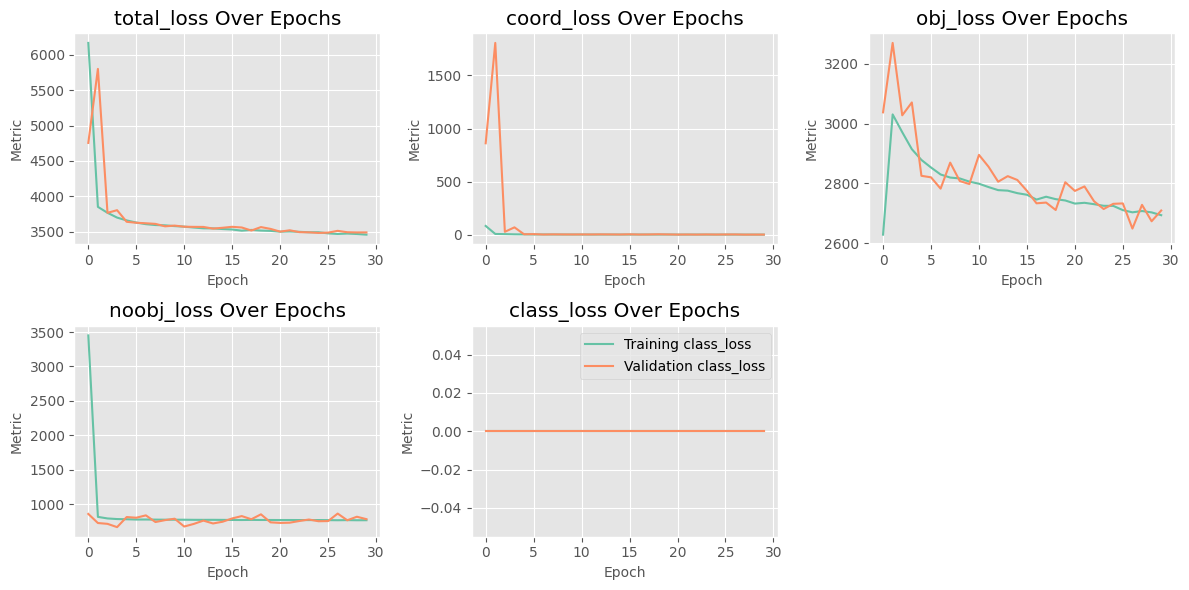

In [10]:
from models.train_val.evaluation import learning_curve

learning_curve(train_history, val_history, save_path='figures/002_learning_curve.png')

## 3. Gradient Accumulation (Batch: 32)

In [ ]:
from data import create_dataloader
from utils import load_config, validate_config
import torch
from utils.data_stream import DataStream
import torchvision.transforms as transforms
from models.yolov3 import YOLOv3
from models.train_val.train import train_model

# PIPELINE

torch.cuda.empty_cache()

data_stream = DataStream(bucket_name=BUCKET_NAME)

config = load_config(os.path.join(CONFIG_PATH, '003_grad_accum.yaml'))
config = validate_config(config)

transform = transforms.Compose([
    transforms.Resize((config['model']['input_size'], config['model']['input_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.25), # diversify perspective
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # diversify lighting condition
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)), # simulate noise
    transforms.RandomResizedCrop(size=416, scale=(0.8, 1.0)), # simulate altitude change
    transforms.RandomRotation(degrees=3) # diversify orientation
])

train_loader, val_loader, test_loader = create_dataloader(
    config=config,
    data_stream=data_stream,
    transform=transform
)

model_003 = YOLOv3(n_classes=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_003 = model_003.to(device)

model_003, train_history, val_history = train_model(
    model=model_003,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device
)

/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/automatedtomato/github.com/automatedtomato/sar-yolo/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Train Samples: 6129, Val Samples: 2043, Test Samples: 2043
cuda
Training model...
  Number of epochs: 30
  Device: cuda
  Patience: 5
  Save path: 003_best_model.pt



Failed to load image from data/new_dataset3/train/images/flood_image0458_0.png: Checksum mismatch while downloading:

  https://storage.googleapis.com/download/storage/v1/b/sar-dataset/o/data%2Fnew_dataset3%2Ftrain%2Fimages%2Fflood_image0458_0.png?alt=media

The X-Goog-Hash header indicated an CRC32C checksum of:

  Tjhvvg==

but the actual CRC32C checksum of the downloaded contents was:

  6pCWeg==



  Epoch: 1/30 - Batch: 0/767 - Loss: 64063.9531
      (Coord: 917.5974, Obj: 542.4870, NoObj: 62603.8672, Class: 0.0000)
  Epoch: 1/30 - Batch: 100/767 - Loss: 13421.5439
      (Coord: 109.5045, Obj: 1747.4968, NoObj: 11564.5430, Class: 0.0000)
  Epoch: 1/30 - Batch: 200/767 - Loss: 8004.8589
      (Coord: 106.5617, Obj: 2194.5793, NoObj: 5703.7178, Class: 0.0000)
  Epoch: 1/30 - Batch: 300/767 - Loss: 6169.3677
      (Coord: 98.9471, Obj: 2386.3552, NoObj: 3684.0654, Class: 0.0000)
  Epoch: 1/30 - Batch: 400/767 - Loss: 5202.1836
      (Coord: 95.2822, Obj: 2584.5847, NoObj: 2522.3169, Class: 0.0000)
  Epoch: 1/30 - Batch: 500/767 - Loss: 4797.1807
      (Coord: 85.6112, Obj: 2765.3499, NoObj: 1946.2195, Class: 0.0000)
  Epoch: 1/30 - Batch: 600/767 - Loss: 4267.5850
      (Coord: 68.5687, Obj: 2589.9719, NoObj: 1609.0446, Class: 0.0000)
  Epoch: 1/30 - Batch: 700/767 - Loss: 4208.3496
      (Coord: 65.2627, Obj: 2745.5356, NoObj: 1397.5510, Class: 0.0000)

Epoch 1/30 finished.
	Learn

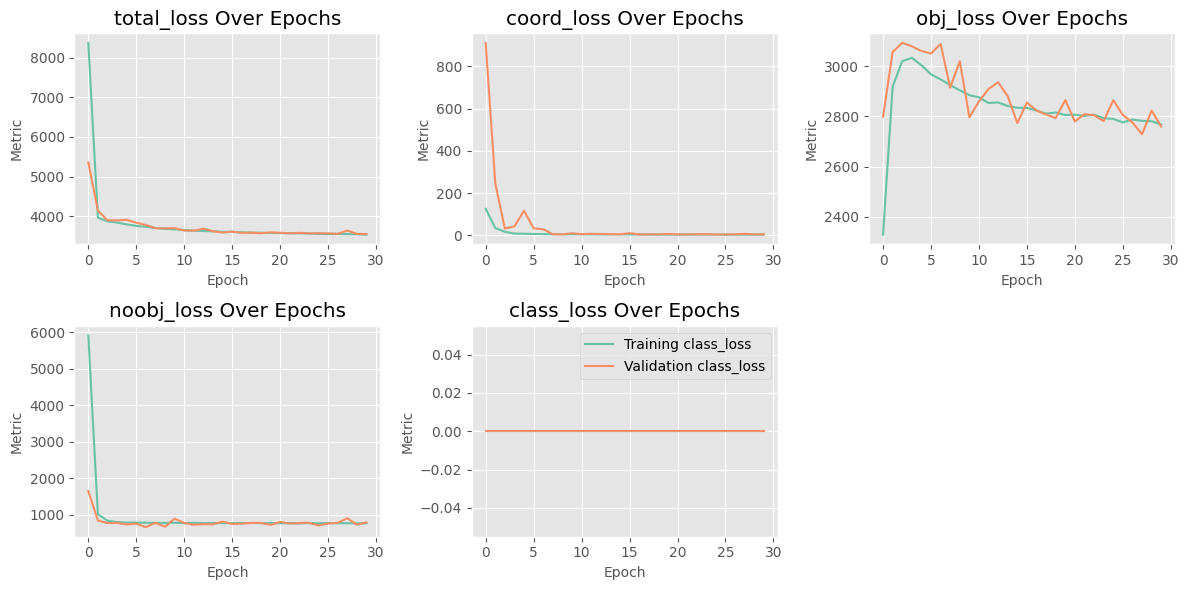

In [14]:
from models.train_val.evaluation import learning_curve

learning_curve(train_history, val_history, save_path='figures/003_learning_curve.png')

IndexError: argmax(): Expected reduction dim to be specified for input.numel() == 0.

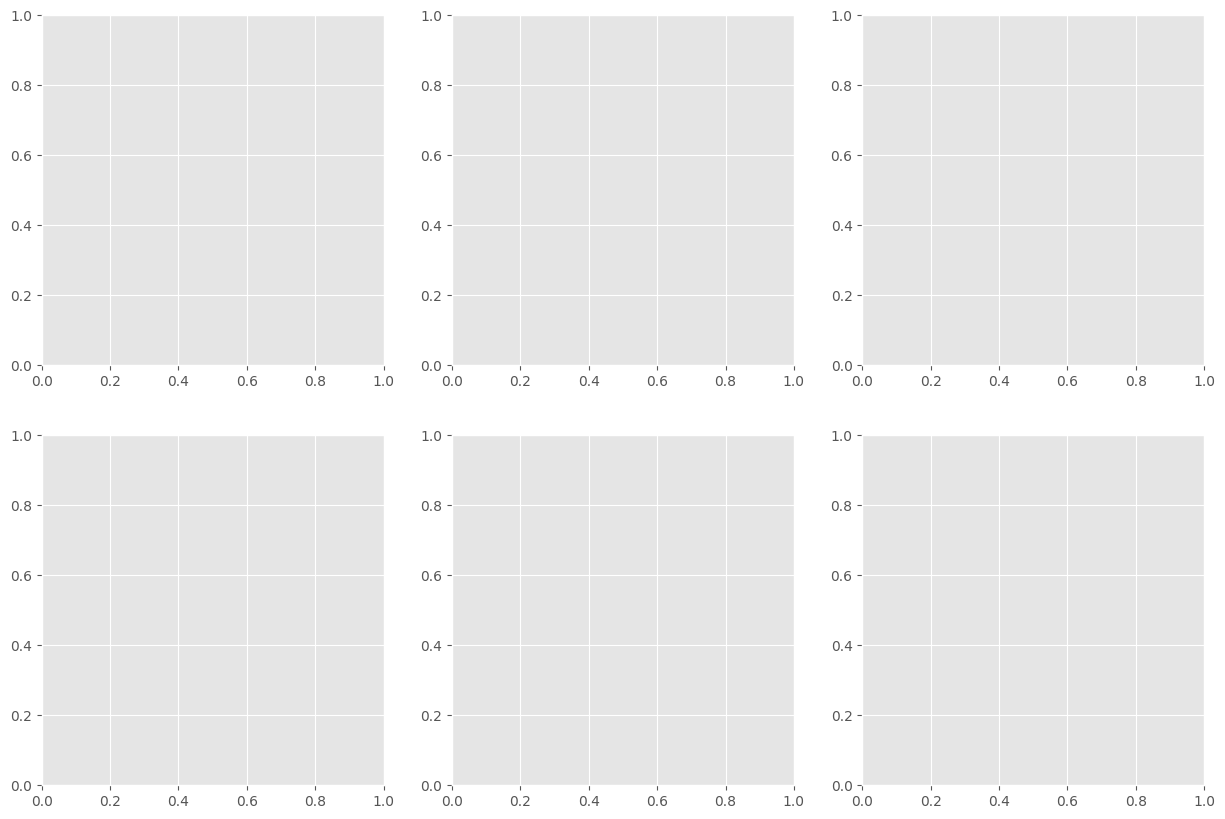

In [15]:
from models.train_val.evaluation import visualize_training_predictions

visualize_training_predictions(
    model=model_003,
    train_loader=train_loader,
    val_loader=val_loader,
    class_names=['Object'],
    device=device,
    save_dir='figures/003_predictions/',
    num_samples=6
)